# Salary Prediction Model

## Data Collection and Pre processing

Importing required libraries

- pandas : For holding data in a data frame,
- matplolib's pyplot function: For plotting data. 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

Sampling

- Loading a external dataset surveyed by stackOverflow with its users about various info such as salary, education, location, etc. in the year 2023.
- we use this dataset to make predictions about the salary distribution.

In [4]:
df = pd.read_csv('Datasets/survey_results_public.csv')
df.head()

,Age,Country,Employment,EdLevel,YearsCodePro,Industry,ConvertedCompYearly
0,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN
1,25-34 years old,United States of America,"Employed, full-time","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,"Information Services, IT, Software Development...",285000.0
2,45-54 years old,United States of America,"Employed, full-time","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",23,"Information Services, IT, Software Development...",250000.0
3,25-34 years old,United States of America,"Employed, full-time","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,NaN,156000.0
4,25-34 years old,Philippines,"Employed, full-time;Independent contractor, fr...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,Other,23456.0


Feature Selection

- We use the columns 'Country', 'EdLevel', 'YearsCodePro', 'Employment', 'ConvertedCompYearly' for training our model
- Hence we delete the unwanted columns and use only the columns that are required for training the model.
- we also changed 'ConvertedCompYearly' to 'Salary' for easier use later on. 

In [5]:
df = df[['Country', 'EdLevel', 'YearsCodePro', 'Employment', 'ConvertedCompYearly']]
df = df.rename({
    'EdLevel' : 'Education',
    'ConvertedCompYearly':'Salary',
    'YearsCodePro' : 'Experience'
    },
        axis=1)
df.head(3)

,Country,Education,Experience,Employment,Salary
0,NaN,NaN,NaN,NaN,NaN
1,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,"Employed, full-time",285000.0
2,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",23,"Employed, full-time",250000.0


Data cleaning

- The null values in the dataset are not useful for training the model
- We are only using the columns were the type of employment is Employed, full-time to better suit our needs 

In [6]:
df = df[df['Salary'].notnull()]
df.head()

,Country,Education,Experience,Employment,Salary
1,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,"Employed, full-time",285000.0
2,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",23,"Employed, full-time",250000.0
3,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,"Employed, full-time",156000.0
4,Philippines,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,"Employed, full-time;Independent contractor, fr...",23456.0
5,United Kingdom of Great Britain and Northern I...,Some college/university study without earning ...,21,"Employed, full-time",96828.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48019 entries, 1 to 89171
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     48019 non-null  object 
 1   Education   48019 non-null  object 
 2   Experience  47825 non-null  object 
 3   Employment  48007 non-null  object 
 4   Salary      48019 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.2+ MB


In [8]:
df.isnull().sum()

Country         0
Education       0
Experience    194
Employment     12
Salary          0
dtype: int64

In [9]:
df = df.dropna()
df.isnull().sum()

Country       0
Education     0
Experience    0
Employment    0
Salary        0
dtype: int64

In [10]:
df = df[df['Employment'] == 'Employed, full-time']
df = df.drop('Employment', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39155 entries, 1 to 89171
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     39155 non-null  object 
 1   Education   39155 non-null  object 
 2   Experience  39155 non-null  object 
 3   Salary      39155 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.5+ MB


In [11]:
df['Country'].value_counts()

Country
United States of America                                10569
Germany                                                  3201
United Kingdom of Great Britain and Northern Ireland     3072
Canada                                                   1807
India                                                    1600
                                                        ...  
Botswana                                                    1
Sierra Leone                                                1
Guyana                                                      1
Guinea-Bissau                                               1
Antigua and Barbuda                                         1
Name: count, Length: 165, dtype: int64

- The countries where there are not enough samples could reflect a wrong prediction if used for prediction
- So we remove the countries where there are samples less than a threshold number that seems to be sufficient for prediction

In [12]:
threshold = 500
country_counts = df['Country'].value_counts()
countries_to_keep = country_counts[country_counts >= threshold].index
df = df[df['Country'].isin(countries_to_keep)]


In [13]:
df.head(3)

,Country,Education,Experience,Salary
1,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,285000.0
2,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",23,250000.0
3,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,156000.0


In [14]:
df.Country.value_counts()

Country
United States of America                                10569
Germany                                                  3201
United Kingdom of Great Britain and Northern Ireland     3072
Canada                                                   1807
India                                                    1600
France                                                   1458
Netherlands                                              1002
Australia                                                 985
Brazil                                                    972
Spain                                                     966
Sweden                                                    882
Italy                                                     826
Poland                                                    740
Switzerland                                               511
Name: count, dtype: int64

In [15]:
df['Country'].unique()

array(['United States of America',
       'United Kingdom of Great Britain and Northern Ireland',
       'Australia', 'Netherlands', 'Germany', 'Sweden', 'France', 'Spain',
       'Brazil', 'Italy', 'Canada', 'Switzerland', 'India', 'Poland'],
      dtype=object)

Remove the outliers from the DataFrame

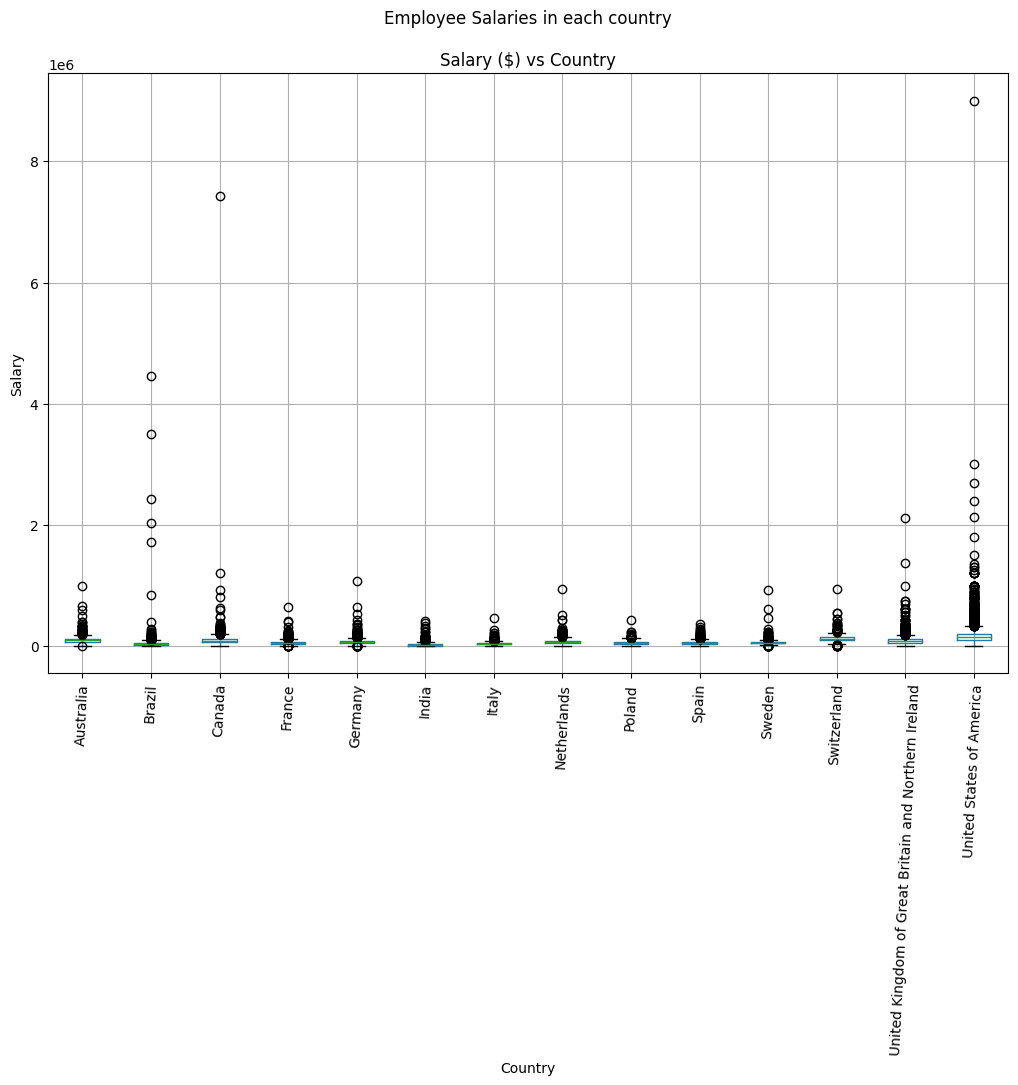

In [16]:
fig,ax =  plt.subplots(1,1, figsize = (12, 8))
df.boxplot('Salary', 'Country', ax = ax)
plt.title('Salary ($) vs Country')
plt.suptitle('Employee Salaries in each country')
plt.xticks(rotation = 87)
plt.ylabel('Salary')
plt.show()

In [17]:
df = df[df['Salary'] <= 600000] 
df = df[df['Salary'] >= 10000]

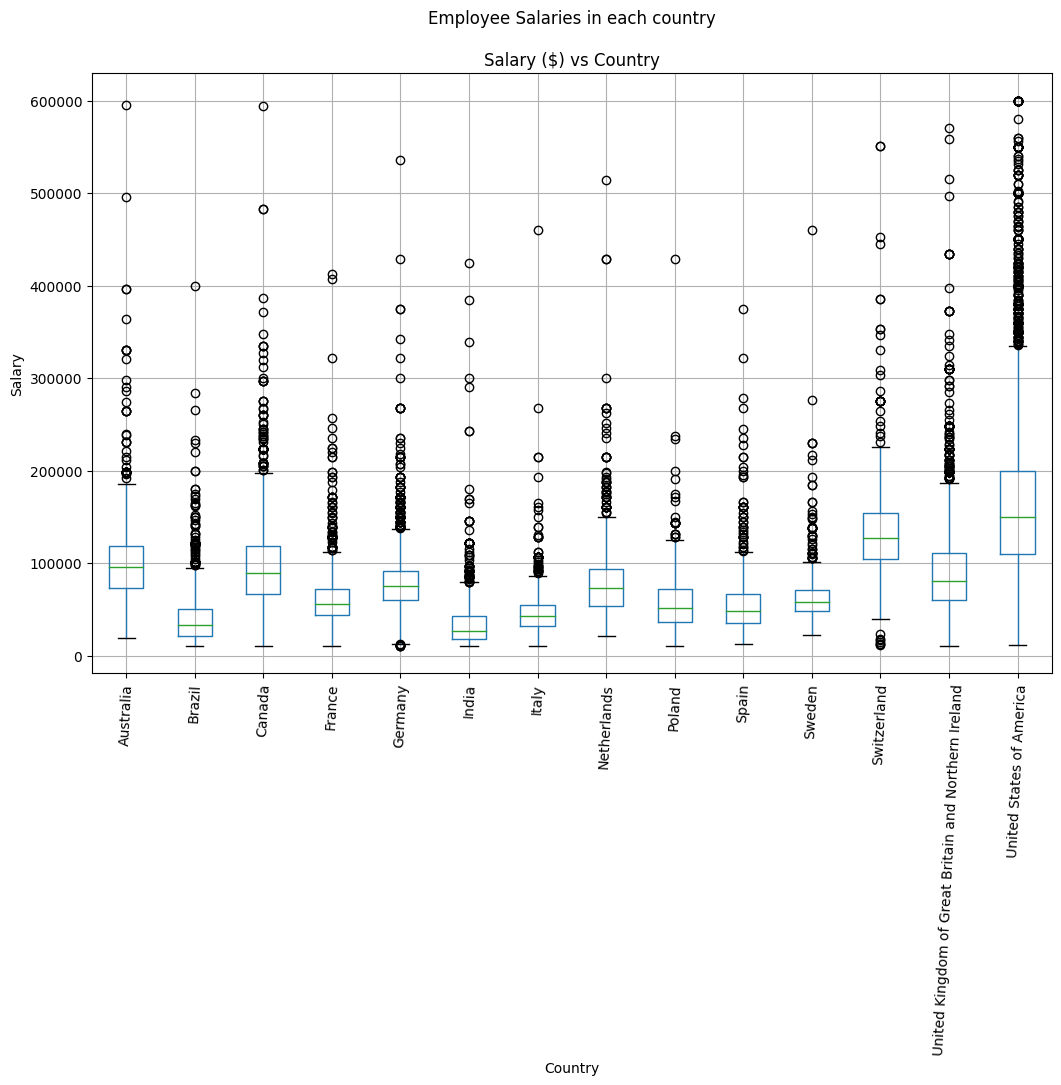

In [18]:
fig,ax =  plt.subplots(1,1, figsize = (12, 8))
df.boxplot('Salary', 'Country', ax = ax)
plt.title('Salary ($) vs Country')
plt.suptitle('Employee Salaries in each country')
plt.xticks(rotation = 87)
plt.ylabel('Salary')
plt.show()

In [19]:
df['Experience'].unique()

array(['9', '23', '7', '21', '3', 'Less than 1 year', '10', '2', '6',
       '14', '5', '15', '19', '13', '16', '28', '24', '25', '12', '4',
       '20', '8', '18', '27', '17', '43', '38', '33', '29', '22', '1',
       '11', '42', '26', '31', '30', '36', '39', '34', '40', '32', '44',
       '37', '35', '48', 'More than 50 years', '45', '41', '50', '46',
       '49', '47'], dtype=object)

In [20]:
def experience_cleaner(value):
    if value == "More than 50 years":
        return 50
    elif value == "Less than 1 year":
        return 0.5
    return float(value)

In [21]:
df['Experience'] = df['Experience'].apply(experience_cleaner)

In [22]:
df['Education'].unique()

array(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Some college/university study without earning a degree',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Professional degree (JD, MD, Ph.D, Ed.D, etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Primary/elementary school', 'Something else'], dtype=object)

In [23]:
def education_cleaner(education_level):
    if "Bachelor’s degree" in education_level:
        return 'Bachelors degree'
    if "Master’s degree" in education_level:
        return 'Masters degree'
    if "Professional degree" in education_level:
        return 'Post graduate'
    return 'Less than Bachelors'

In [24]:
df['Education'] = df['Education'].apply(education_cleaner)
df['Education'].unique()

array(['Bachelors degree', 'Less than Bachelors', 'Masters degree',
       'Post graduate'], dtype=object)

In [25]:
le_education = LabelEncoder()
df['Education'] =  le_education.fit_transform(df['Education'])
df['Education'].unique()

array([0, 1, 2, 3])

In [26]:
le_country = LabelEncoder()
df['Country'] =  le_country.fit_transform(df['Country'])
df['Country'].unique()

array([13, 12,  0,  7,  4, 10,  3,  9,  1,  6,  2, 11,  5,  8])

## Model building

As We used a label Encoder it is better to use a algorithm that does not get confused with such encodings
- Random Forest Regressor, DecisionTreeRegressor are good examples

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV

In [28]:
X = df.drop('Salary', axis=1) # Features
y = df['Salary'] # Target


In [29]:
dec_tree_reg = DecisionTreeRegressor(random_state = 9)
dec_tree_reg.fit(X, y.values)

DecisionTreeRegressor(random_state=9)

In [30]:
y_pred = dec_tree_reg.predict(X)

In [31]:
error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.2f}".format(error))

$53,650.26


In [32]:
random_forest_Reg = RandomForestRegressor(random_state= 9)
random_forest_Reg.fit(X, y.values)

RandomForestRegressor(random_state=9)

In [33]:
y_pred = random_forest_Reg.predict(X)

In [34]:
error = np.sqrt(mean_squared_error(y,y_pred))
print("${:,.2f}".format(error))

$53,729.31


In [35]:
max_depth = [None, 1, 2, 4, 6, 8, 10, 12, 14]
parameters = {'max_depth' : max_depth}

regressor = DecisionTreeRegressor(random_state = 9)
gs = GridSearchCV(regressor, parameters, scoring='neg_mean_squared_error')
gs.fit(X, y.values)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=9),
             param_grid={'max_depth': [None, 1, 2, 4, 6, 8, 10, 12, 14]},
             scoring='neg_mean_squared_error')

In [36]:
regressor = gs.best_estimator_

regressor.fit(X, y.values)
y_pred = regressor.predict(X)
error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.2f}".format(error))

$54,973.43


In [37]:
X = np.array([["Germany", "Masters degree", 1]])
X

array([['Germany', 'Masters degree', '1']], dtype='<U14')

In [38]:

#- Transform the 'Country' column using the fitted LabelEncoder
X[:, 0] = le_country.transform(X[:, 0])

#- Assuming le_education has been fitted to the 'Education' column
#- Transform the 'Education' column
X[:, 1] = le_education.transform(X[:, 1])

In [39]:
X = X.astype(float)
y_pred = regressor.predict(X)
y_pred

c:\Users\sprod\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([48909.60968661])

## Saving the model

In [40]:
import pickle

In [41]:
data = {'model' : regressor,
        'le_country' : le_country,
        'le_education' : le_education}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)

In [42]:
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)

In [43]:
regressor_loaded = data['model']
le_country = data['le_country']
le_education = data['le_education']

In [44]:
y_pred = regressor_loaded.predict(X)
y_pred

c:\Users\sprod\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([48909.60968661])